The overlap of identified proteins will be explored in this notebook. This will give a measure of coherence within and between datasets belonging to the same or different classes. 

Also this will make it possible to identify outlier-samples that have identified very different proteins

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/pooled_proteome_nsaf_1.csv")
data = data.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")
metadata = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/metadata_NSAF_atlas.csv")
dataset = pd.merge(data, metadata[["assay_id", "tissue_type", "PXD_accession"]], on = "assay_id", right_index=True)
#Left out due to not being pooled, due to not all the pool files being available
dataset = dataset[dataset.PXD_accession != "PXD009149"]
#Left out due to <10 protein ids
'''
assay_id    prot_ids
32491       7
32492       4
32493       6
'''
dataset = dataset[~dataset.index.isin([32491, 32492, 32493])]

dataset.reset_index(inplace=True)
assay_ids = dataset.pop("assay_id")
dataset = dataset.loc[:, ~dataset.columns.isin("tissue_type PXD_accession".split())]
metadata = metadata[metadata['assay_id'].isin(assay_ids)].reset_index(drop = True)

In [5]:
def pxd_parser(dataset: pd.DataFrame, labels: pd.DataFrame, frequency_cutoff = .5):
    '''Groups assays by project by only keeping protein identifications identified in frequency_cutoff % of all the samples in the project
    
    dataset: matrix with quantification values; columns = protein ids; rows = samples
    
    labels: dataframe with PXD and assay_ids matching the index of dataset
    
    Returns parsed_dataset, updated_metadata'''

    pxd_assay_dict = labels.groupby("PXD_accession").assay_id.unique().to_dict()
    pxd_proteins_dict = {}
    
    for pxd, assay_list in pxd_assay_dict.items():
        assay_indeces = labels[labels.assay_id.isin(assay_list)].index

        protein_identifications = _return_common_proteins(dataset, assay_indeces, frequency_cutoff=frequency_cutoff, pxd=pxd)
        df_format = [1 if (protein in protein_identifications) else np.NaN for protein in dataset.columns ]
        
        pxd_proteins_dict[pxd] = df_format
        
    parsed_dataset = pd.DataFrame.from_dict(pxd_proteins_dict, orient = "index", columns = dataset.columns)
    updated_metadata = pd.Series(parsed_dataset.index)

    return parsed_dataset, updated_metadata

def _return_common_proteins(df, indeces, frequency_cutoff, pxd):
    '''Returns list of protein identifications that are in percentage frequency_cutoff or more of the assays.
    
    df = dataframe
    
    indeces = corresponding df indeces that needs common_protein pooling.'''
    
    proteins_per_assay = df[df.index.isin(indeces)].notna().sum(axis = 1)

    df_proteins_ided = df[df.index.isin(indeces)].notna().sum() /  len(indeces)
    proteins_ided = df_proteins_ided[df_proteins_ided >= frequency_cutoff].index.tolist()
    
    mean_ = (proteins_per_assay.sum()/len(proteins_per_assay))
    percentage = len(proteins_ided)/mean_ *100

    print(f"Mean remaining percentage of p_ids in {pxd}: {percentage}")
    return proteins_ided

def get_proteins(row, upperbound = 1, lowerbound = 0) -> list:
    '''Outputs list of proteins identified in a sample (row) with following limits:
    
    - upperbound: limits top x percent of the most quantified proteins. e.g. 1 = most quantified, 0.75 = drop most 25% quantified proteins
    - lowerbound: drops x percent proteins with lowest quantification. e.g. 0 = least quantified, 0.25 = drop least 25% quantified proteins
    
    Note: upperbound > lowerbound!
    
    Example: upperbound = .75, lowerbound = .30 --> get all protein identifications but the top 25% and lowest 30% of the protein quantifications.'''


    row = row[row.notna()].sort_values(ascending = True) # Sorted with index 0 = least quantified protein
    total_amount = len(row)
    upper_index = round(total_amount * upperbound)
    lower_index = round(total_amount * lowerbound)

    proteins = row[lower_index:upper_index].index.tolist()
    return proteins

def split_dataset(dataset: pd.DataFrame, split_labels: pd.Series, upperbound = 1, lowerbound = 0, subset_labels = []):
    '''returns dict with list of lists values containing the identified proteins for each sample. Keys are label names.
    
    dataset: contains quantification values for each protein identified (columns) and labels being the provided as series with same indexing
    
    split_labels: labels to group on
    
    - upperbound: limits top x percent of the most quantified proteins. e.g. 1 = most quantified, 0.75 = drop most 25% quantified proteins
    - lowerbound: drops x percent proteins with lowest quantification. e.g. 0 = least quantified, 0.25 = drop least 25% quantified proteins
    
    Note: upperbound > lowerbound!
    
    Example: upperbound = .75, lowerbound = .30 --> get all protein identifications but the top 25% and lowest 30% of the protein quantifications.
    '''
    flag = True
    if subset_labels == []:
        flag = False

    if upperbound < lowerbound:
        print("Make sure: upperbound > lowerbound !")
        return 

    output_df = {}

    for label in split_labels.unique():
        if (label not in subset_labels) and flag:
            continue
        output_df[label] = []
        label_indeces = split_labels[split_labels == label].index # Indexing based on the labels of the metadata series
        subset = dataset.loc[dataset.index.isin(label_indeces)] # Get subset of the data corresponding to the label indeces

        label_counter = 0
        for index, sample in subset.iterrows():
            output_df[label] += [(label_indeces[label_counter],get_proteins(row=sample, upperbound=upperbound, lowerbound=lowerbound))]
            label_counter += 1

    return output_df

def count_duplicates(list_1, list_2):
    count = 0
    for x in list_1:
        if x in list_2:
            count+=1
    return count

def analyse_coherence(splitted_dataset, return_info = False):
    
    info = {}
    output = {}
    for key, values in splitted_dataset.items():
        output[key] = []
        print(key)
        for i1, sample_1 in enumerate(values):

            for i2, sample_2 in enumerate(values):
                if i1 == i2: # Do not compare the same samples
                    continue
                if len(sample_2[1]) > len(sample_1[1]): # Only compare with a sample with less ids --> ensures pairwise comparison
                    continue
                
                duplicates = count_duplicates(sample_1[1], sample_2[1])
                decoherence_factor = (1 - duplicates/len(sample_2[1])) * (len(sample_1[1])/len(sample_2[1]))
                output[key] += [decoherence_factor]
                
                if return_info:
                    info[(sample_1[0], sample_2[0])] = decoherence_factor
    if return_info:
        return output, info
    return output

def plot_decoherence_pp(output_dictionary, leftlim = -.1, rightlim = 2):
    
    plt.figure(figsize = (20,3*len(output_dictionary)))

    counter = 0
    for key, values in output_dictionary.items():
        counter += 1
        plt.subplot(round(len(output_dictionary)/3)+1, 3, counter)
        plt.title(key)
        plt.xlim(left = leftlim, right = rightlim)
        sns.histplot(values)

def plot_mean_std(output_dictionary):
    mean_ = []
    std_ = []

    for key, values in output_dictionary.items():
        mean_.append(np.mean(values))
        std_.append(np.std(values))
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title("Mean decoherence within projects")
    sns.histplot(mean_, bins = 30)
    plt.subplot(122)
    plt.title("std decoherence within projects")
    sns.histplot(std_, bins = 30)

In [15]:
print(dataset.shape, metadata.shape)

(510, 13166) (510, 4)


In [13]:
dataset.head()

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000070,0.000016,0.000028,0.000040,0.000062,NaN,0.000088,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000068,0.000016,0.000033,0.000042,0.000045,0.000001,0.000075,NaN,NaN,NaN
2,0.000011,NaN,0.000061,NaN,NaN,0.000016,NaN,0.000002,NaN,NaN,...,NaN,NaN,0.000007,0.000024,0.000045,NaN,0.000092,0.000024,NaN,NaN
3,0.000011,NaN,0.000080,NaN,NaN,0.000016,NaN,0.000002,NaN,NaN,...,NaN,NaN,0.000005,0.000035,0.000033,NaN,0.000076,0.000024,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000350,NaN,NaN,NaN


In [1]:
metadata.groupby("PXD_accession").nunique()

NameError: name 'metadata' is not defined

In [15]:
metadata.groupby(["cell_line"]).PXD_accession.unique()[metadata.groupby(["cell_line"]).PXD_accession.nunique() > 2]

cell_line
HEK293    [PXD006035, PXD008693, PXD001468, PXD003896, P...
HeLa      [PXD000612, PXD004182, PXD004940, PXD001441, P...
Jurkat                    [PXD004280, PXD000443, PXD000426]
MCF7           [PXD008719, PXD001352, PXD007543, PXD005940]
Name: PXD_accession, dtype: object

### Within a project

In [11]:
output = split_dataset(dataset, metadata.PXD_accession)

In [39]:
coherence_output = analyse_coherence(output)

PXD000533
PXD004280
PXD002842
PXD008996
PXD006035
PXD008719
PXD006591
PXD003406
PXD003407
PXD001327
PXD002057
PXD001352
PXD000661
PXD008381
PXD005045
PXD000529
PXD000443
PXD010538
PXD009442
PXD009560
PXD003252
PXD007543
PXD008693
PXD000426
PXD007759
PXD018066
PXD017391
PXD016742
PXD001468
PXD000612
PXD003903
PXD003896
PXD002613
PXD004182
PXD005912
PXD004940
PXD001441
PXD003790
PXD003530
PXD006112
PXD003668
PXD004452
PXD005354
PXD004900
PXD008222
PXD005940


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


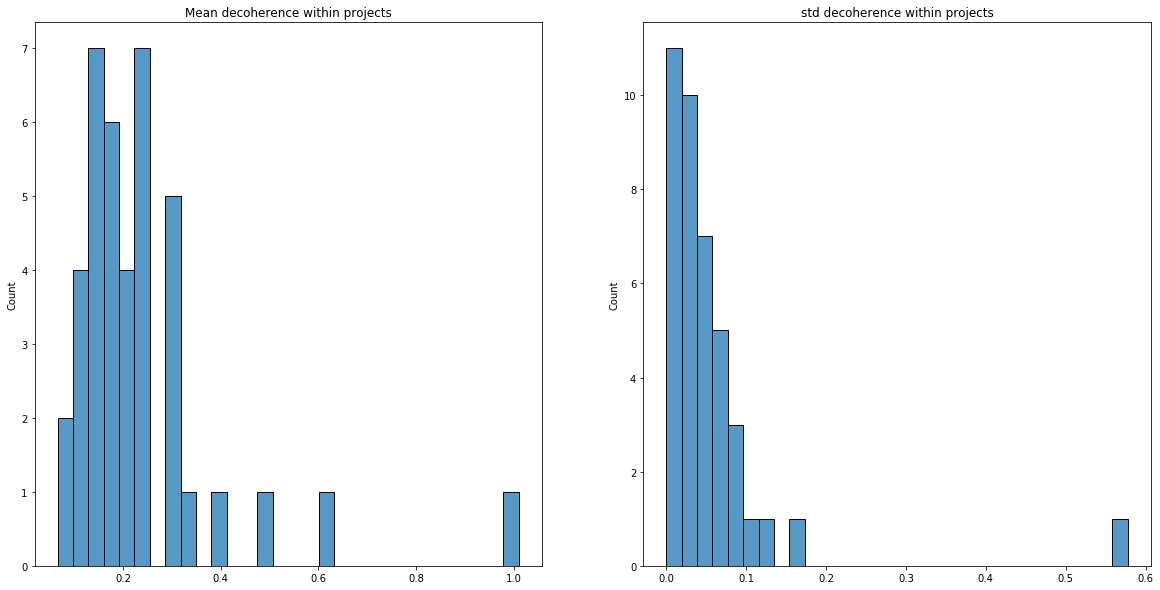

In [78]:
plot_mean_std(coherence_output)

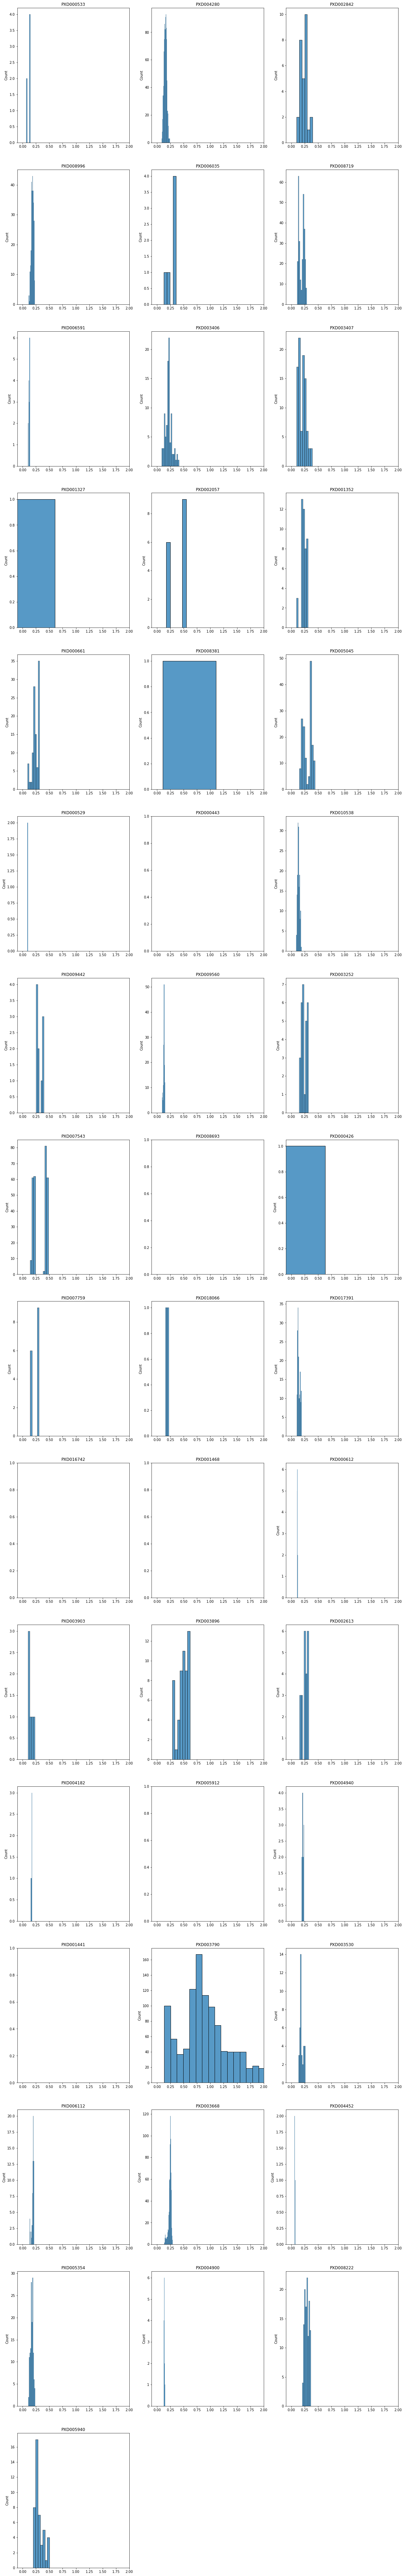

In [96]:
plot_decoherence_pp(coherence_output)

### Between classes across projects

liver
blood
brain
skin
fetal kidney
breast
umbilical vein
colon
lung
prostate
trophoblast
ovary
kidney
cervix
fibroblast
/
T-cell


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


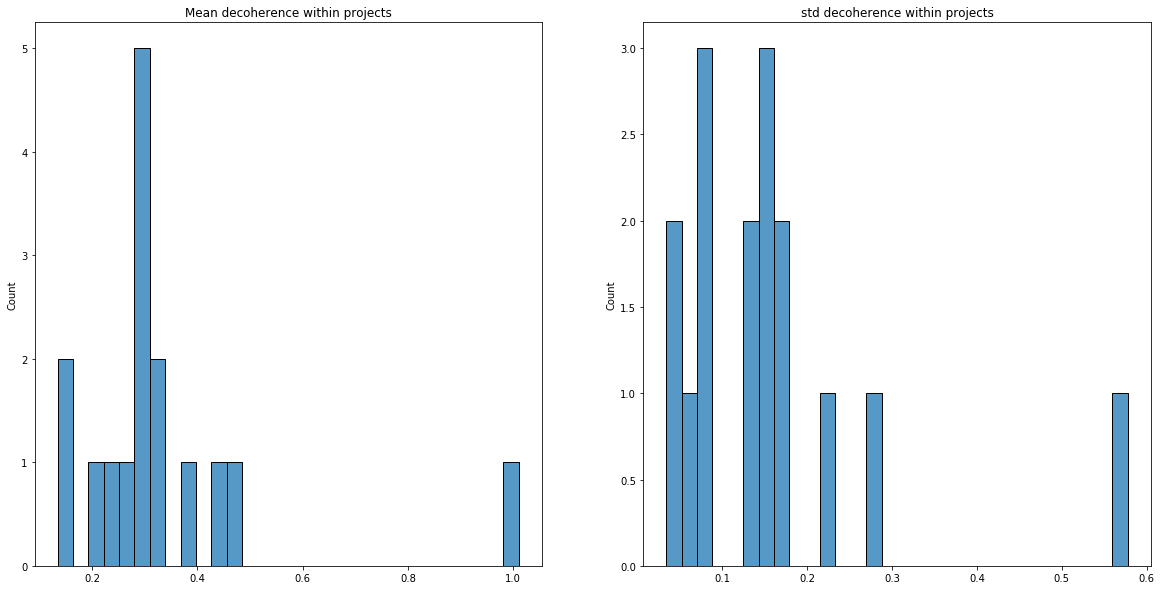

In [80]:
tissue_split_dataset = split_dataset(dataset, metadata.tissue_type)
tissue_coherence_output = analyse_coherence(tissue_split_dataset)
plot_mean_std(tissue_coherence_output)

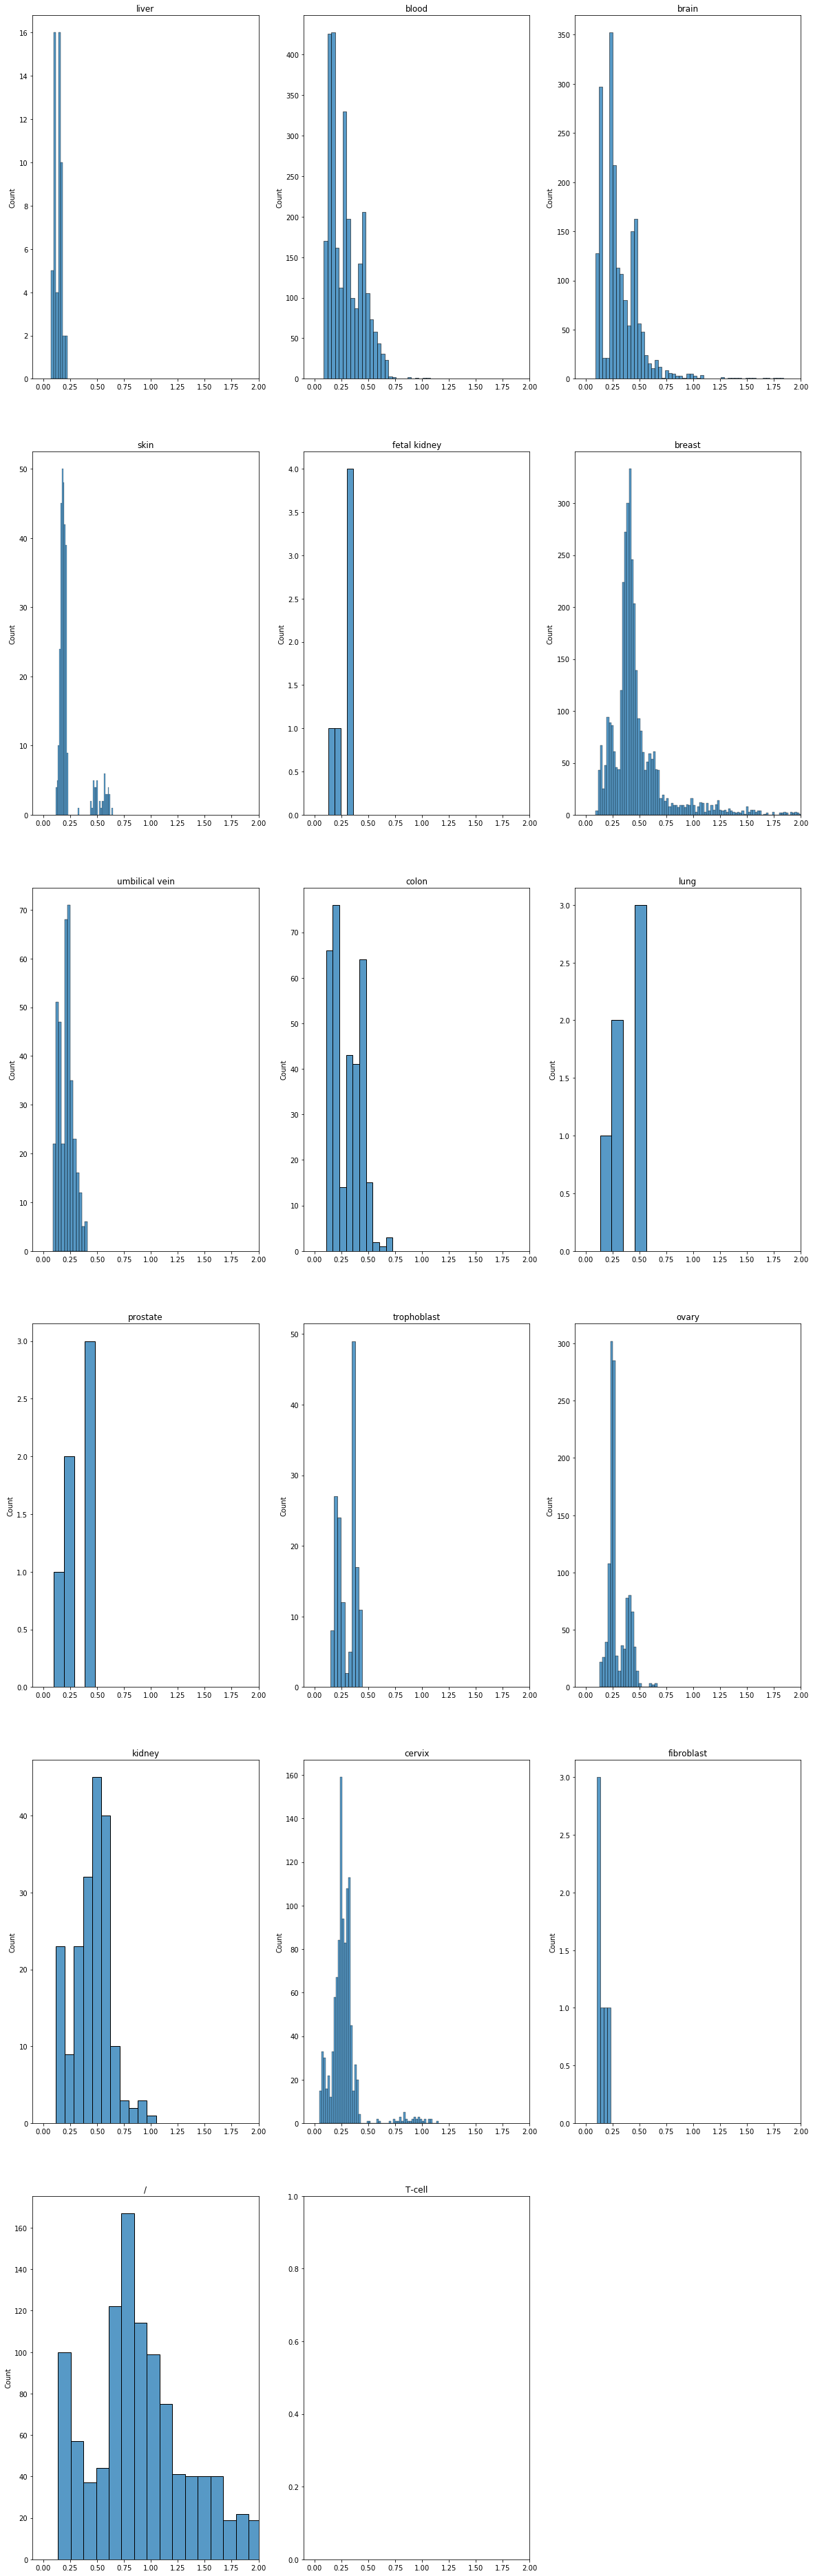

In [85]:
plot_decoherence_pp(tissue_coherence_output)

Now only top 75% identified proteins

liver
blood
brain
skin
fetal kidney
breast
umbilical vein
colon
lung
prostate
trophoblast
ovary
kidney
cervix
fibroblast
/
T-cell


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


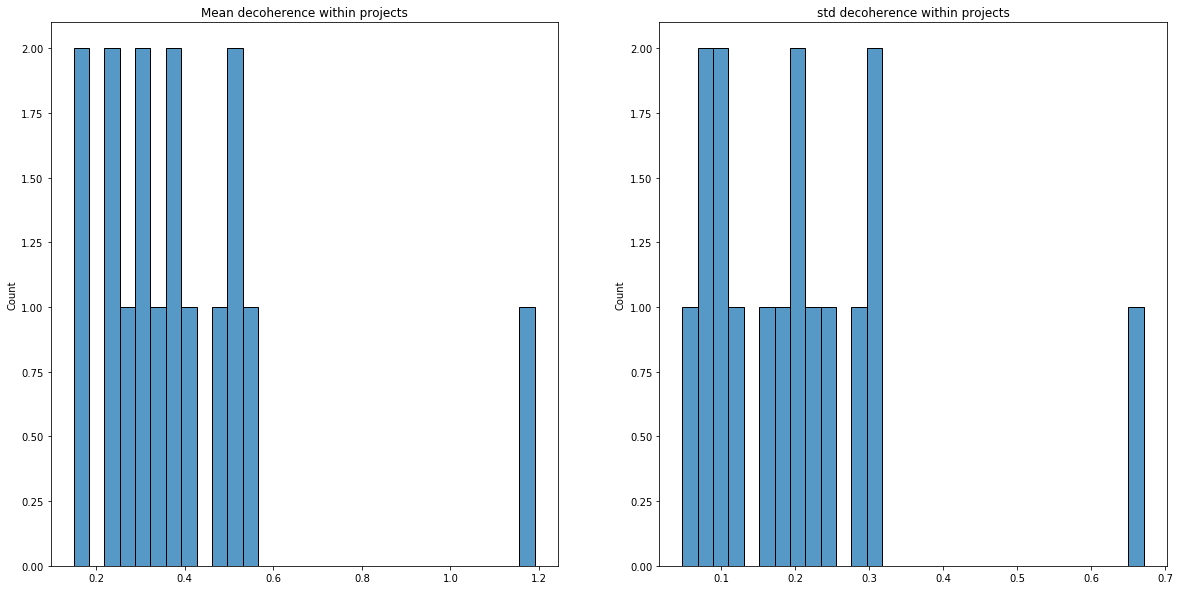

In [9]:
tissue_split_dataset_top75 = split_dataset(dataset, metadata.tissue_type, upperbound = 1, lowerbound = 0.50)
tissue_coherence_output_top75 = analyse_coherence(tissue_split_dataset_top75)
plot_mean_std(tissue_coherence_output_top75)

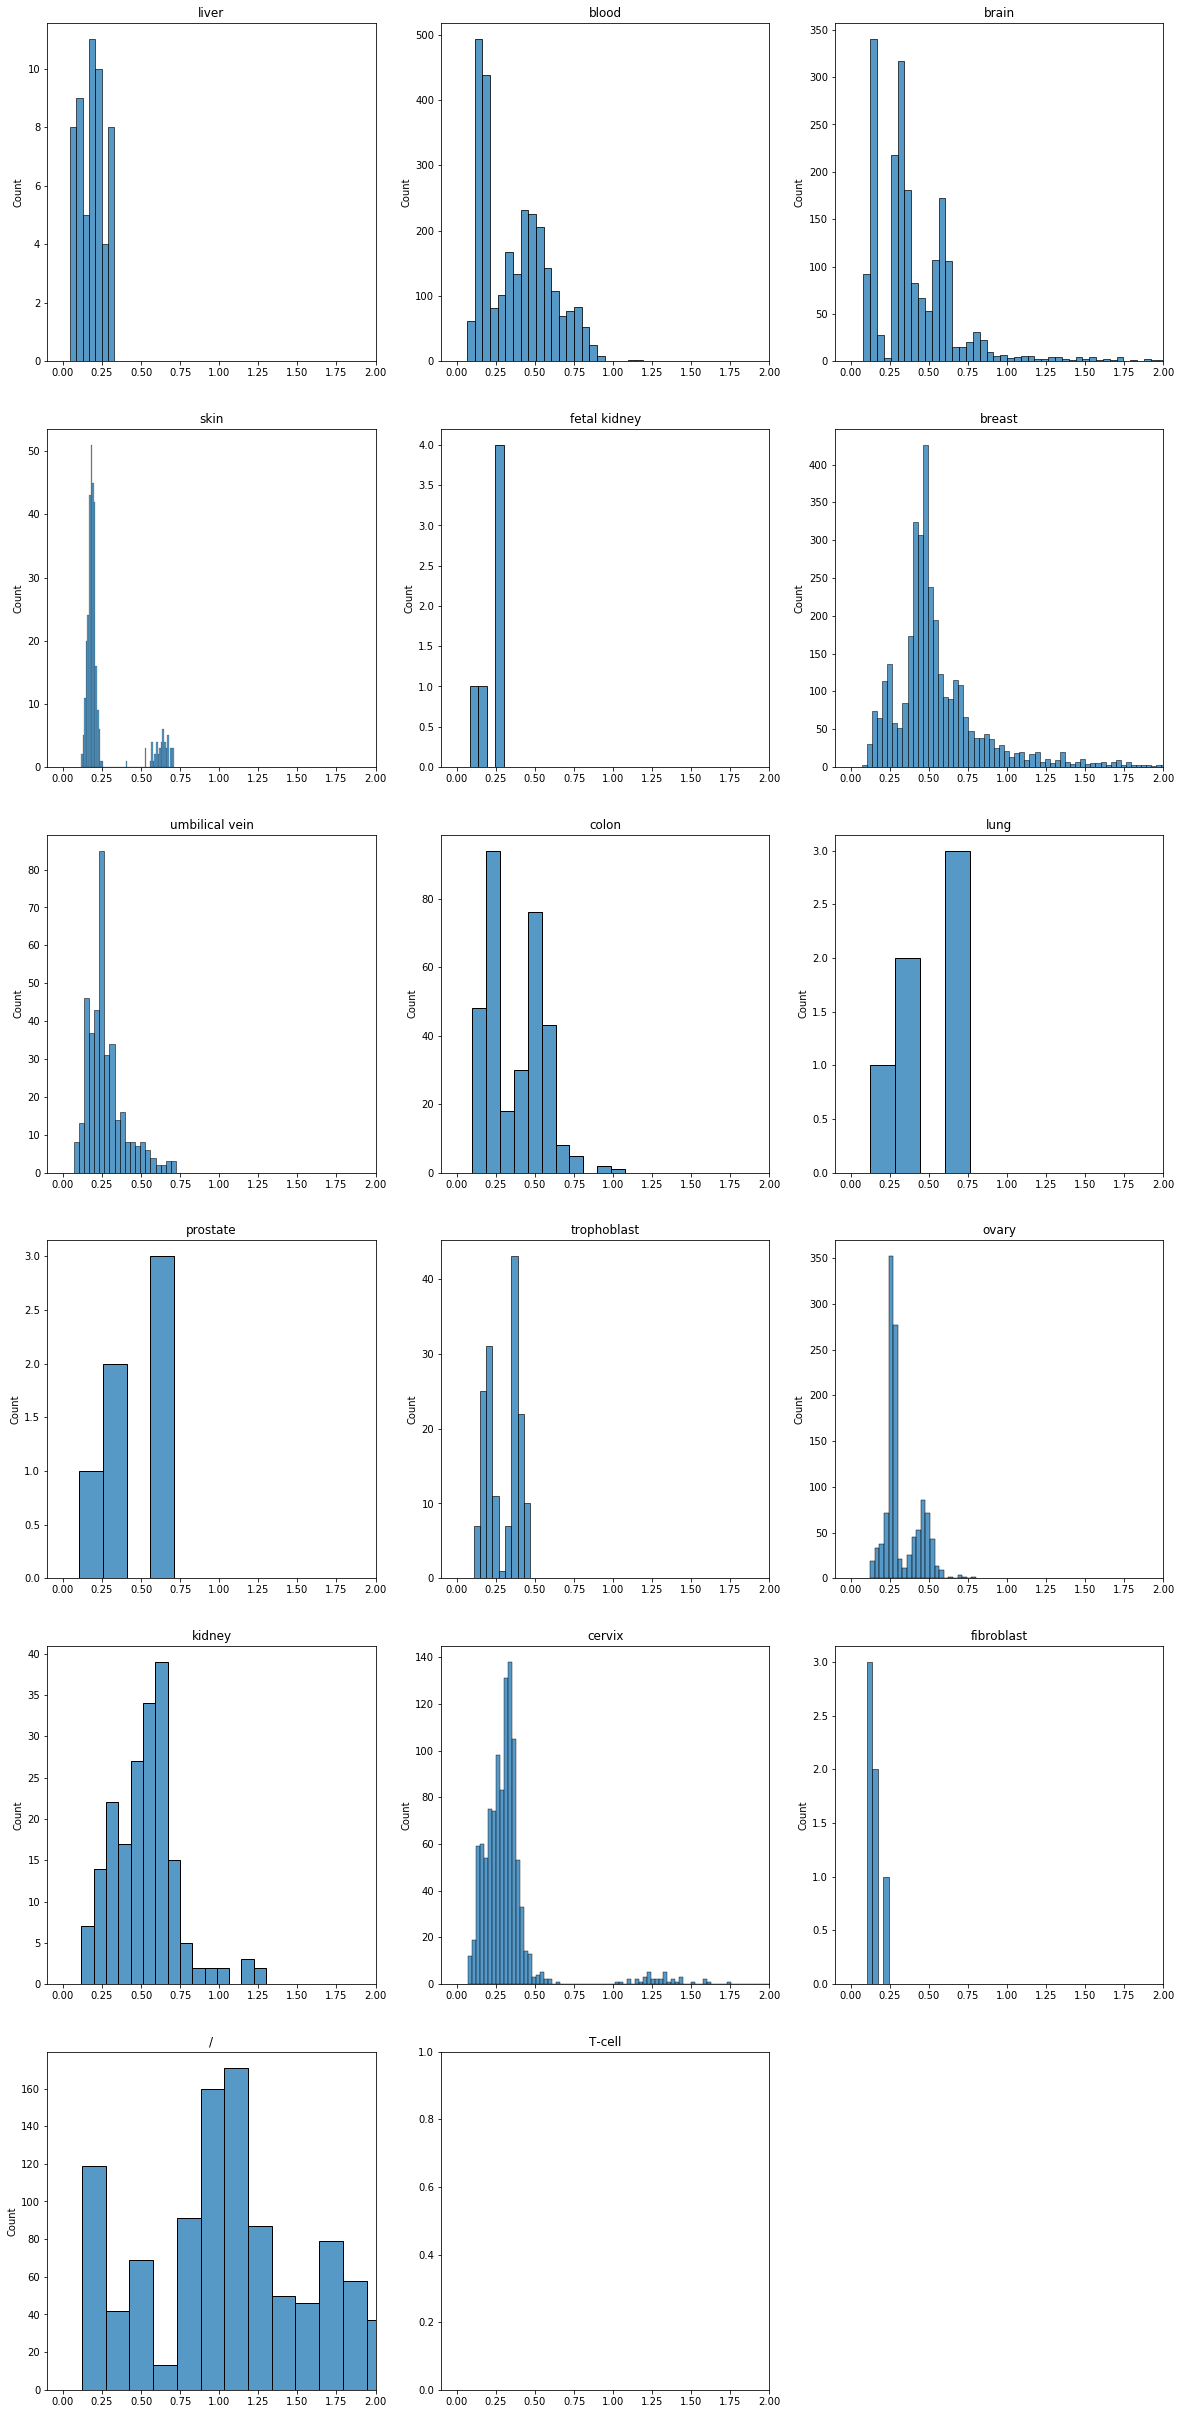

In [10]:
plot_decoherence_pp(tissue_coherence_output_top75)

### Between cells analysed in different labs

Jurkat
HEK293
MCF7
HeLa


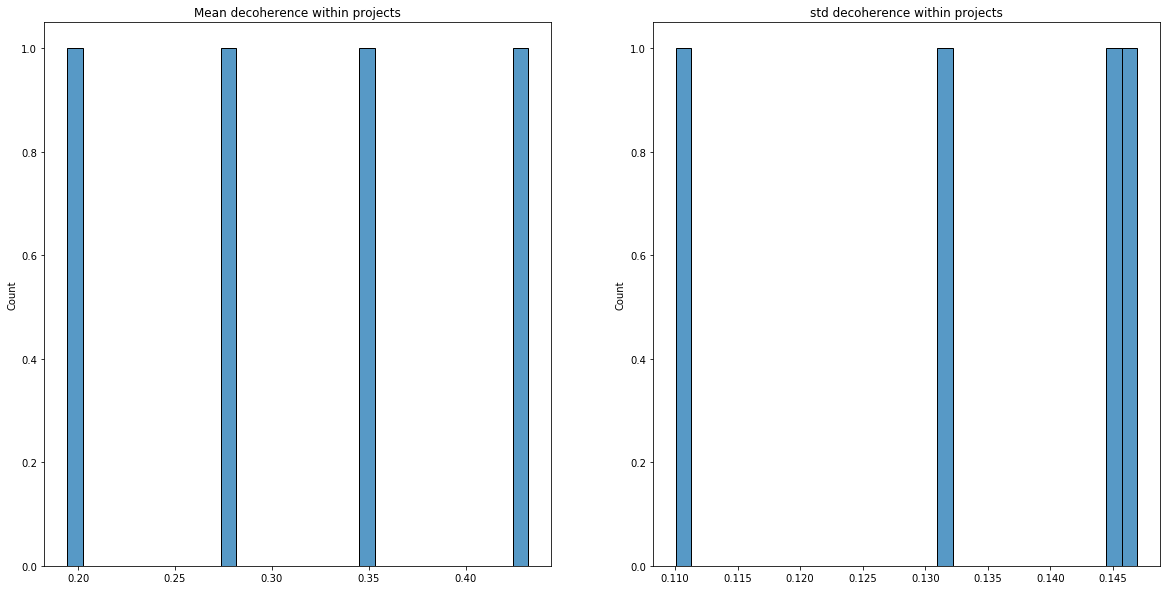

In [16]:
cell_split_dataset = split_dataset(dataset, metadata.cell_line, subset_labels=["HEK293", "HeLa", "Jurkat", "MCF7"])
cell_coherence_output = analyse_coherence(cell_split_dataset)
plot_mean_std(cell_coherence_output)

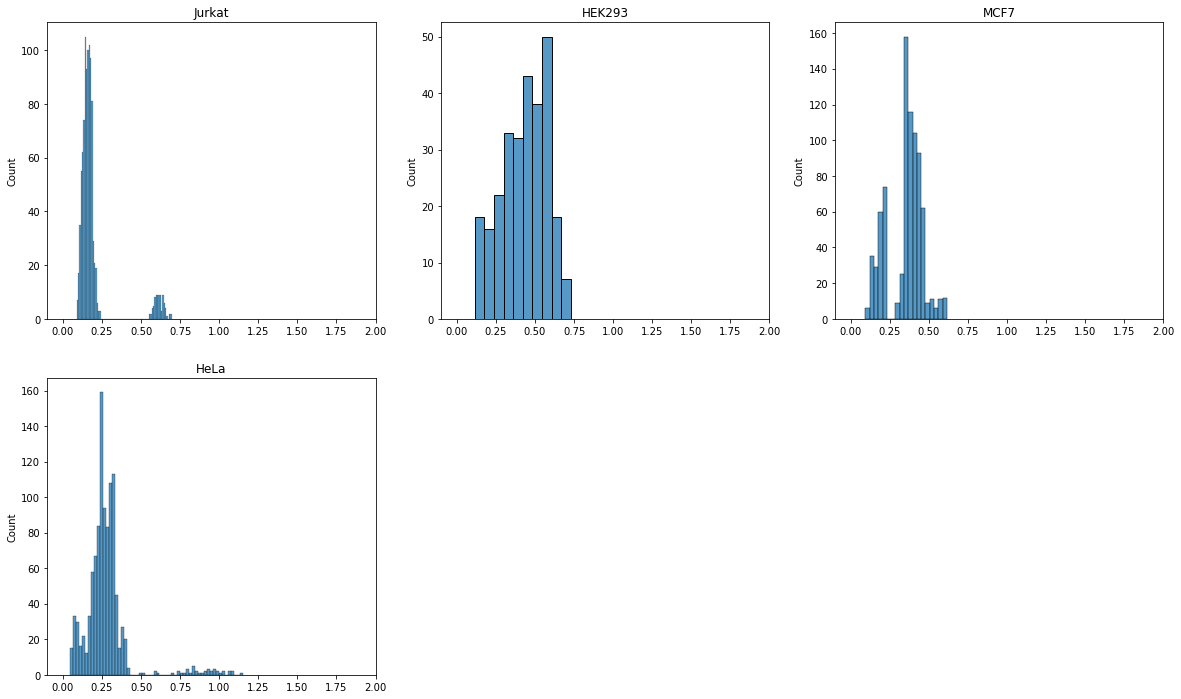

In [17]:
plot_decoherence_pp(cell_coherence_output)

### Across all projects where each project is pooled for x reoccuring proteins

In [50]:
pooled_dataset, pooled_metadata = pxd_parser(dataset, metadata, frequency_cutoff=.5)

Mean remaining percentage of p_ids in PXD000426: 113.71228070175438
Mean remaining percentage of p_ids in PXD000443: 100.0
Mean remaining percentage of p_ids in PXD000529: 104.11300101596042
Mean remaining percentage of p_ids in PXD000533: 107.33036156513126
Mean remaining percentage of p_ids in PXD000612: 100.95043594375932
Mean remaining percentage of p_ids in PXD000661: 94.23896165943387
Mean remaining percentage of p_ids in PXD001327: 110.78220462954995
Mean remaining percentage of p_ids in PXD001352: 99.98620879878638
Mean remaining percentage of p_ids in PXD001441: 100.0
Mean remaining percentage of p_ids in PXD001468: 100.0
Mean remaining percentage of p_ids in PXD002057: 112.29946524064172
Mean remaining percentage of p_ids in PXD002613: 90.37786664490329
Mean remaining percentage of p_ids in PXD002842: 109.1975241611467
Mean remaining percentage of p_ids in PXD003252: 101.39117099353707
Mean remaining percentage of p_ids in PXD003406: 100.77202543142599
Mean remaining percenta

1


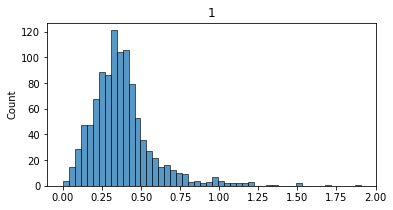

In [82]:
pooled_split_dataset = split_dataset(pooled_dataset.set_index(pd.Series([1]*len(pooled_dataset))), pd.Series([1]*len(pooled_dataset)))
pooled_coherence_output, info = analyse_coherence(pooled_split_dataset, return_info = True)
plot_decoherence_pp(pooled_coherence_output)

In [ ]:
pooled_metadata.iloc[[0,12,]]

In [101]:
pairs = []
for key, decoherence_factor in info.items():
    if decoherence_factor > 1:
        pairs.append((decoherence_factor, key))

In [115]:
pooled_metadata

0     PXD000426
1     PXD000443
2     PXD000529
3     PXD000533
4     PXD000612
5     PXD000661
6     PXD001327
7     PXD001352
8     PXD001441
9     PXD001468
10    PXD002057
11    PXD002613
12    PXD002842
13    PXD003252
14    PXD003406
15    PXD003407
16    PXD003530
17    PXD003668
18    PXD003790
19    PXD003896
20    PXD003903
21    PXD004182
22    PXD004280
23    PXD004452
24    PXD004900
25    PXD004940
26    PXD005045
27    PXD005354
28    PXD005912
29    PXD005940
30    PXD006035
31    PXD006112
32    PXD006591
33    PXD007543
34    PXD007759
35    PXD008222
36    PXD008381
37    PXD008693
38    PXD008719
39    PXD008996
40    PXD009442
41    PXD009560
42    PXD010538
43    PXD016742
44    PXD017391
45    PXD018066
dtype: object

In [117]:
metadata[metadata.PXD_accession.isin(["PXD002057"])]

,assay_id,cell_line,PXD_accession,tissue_type
142,31344,SKBR3,PXD002057,breast
143,31345,SKBR3,PXD002057,breast
144,31346,SKBR3,PXD002057,breast
145,31347,SKBR3,PXD002057,breast
146,31348,SKBR3,PXD002057,breast
147,31349,SKBR3,PXD002057,breast


In [108]:
pooled_dataset.notna().sum(axis = 1)

PXD000426    4051
PXD000443    7151
PXD000529    7942
PXD000533    8668
PXD000612    4284
PXD000661    4734
PXD001327    6437
PXD001352    5075
PXD001441    3511
PXD001468    6521
PXD002057    1330
PXD002613    1582
PXD002842    1257
PXD003252    1157
PXD003406    1902
PXD003407    1970
PXD003530    1074
PXD003668    2966
PXD003790     659
PXD003896     669
PXD003903    5148
PXD004182    2937
PXD004280    1341
PXD004452    6287
PXD004900    1902
PXD004940    1966
PXD005045     528
PXD005354    4082
PXD005912    2605
PXD005940    3151
PXD006035    1984
PXD006112    1699
PXD006591    2308
PXD007543    1791
PXD007759    1500
PXD008222    2771
PXD008381    2443
PXD008693    3638
PXD008719    1872
PXD008996    1279
PXD009442     941
PXD009560    3870
PXD010538    3265
PXD016742    1488
PXD017391    2919
PXD018066    1881
dtype: int64

In [102]:
pairs

[(1.163985420705307, (0, 12)),
 (1.07272710526134, (0, 18)),
 (1.5257511191460054, (0, 26)),
 (1.5209180846853978, (4, 10)),
 (1.1525051652892564, (4, 26)),
 (1.188924755497767, (8, 10)),
 (2.0607377466221948, (9, 10)),
 (1.3098886593204777, (9, 26)),
 (1.0395839222115437, (17, 10)),
 (1.6850539883543445, (20, 10)),
 (1.0710227272727275, (20, 26)),
 (1.0211176437333935, (21, 10)),
 (1.8730561365820566, (23, 10)),
 (1.0599209423783285, (23, 26)),
 (1.3592051557465092, (27, 10)),
 (1.0014133077053535, (28, 10)),
 (1.1186771439877892, (29, 10)),
 (1.0150969529085871, (36, 10)),
 (1.1866843801232407, (37, 10)),
 (1.1989145796822884, (41, 10)),
 (1.1148510373678557, (42, 10))]

---

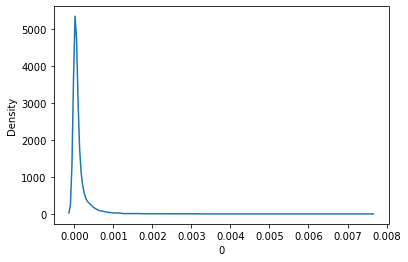

In [11]:
sns.kdeplot(dataset.loc[0,:][dataset.loc[0,:].notna()])

In [3]:
dataset

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000070,0.000016,0.000028,0.000040,0.000062,NaN,0.000088,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000068,0.000016,0.000033,0.000042,0.000045,0.000001,0.000075,NaN,NaN,NaN
2,0.000011,NaN,0.000061,NaN,NaN,0.000016,NaN,0.000002,NaN,NaN,...,NaN,NaN,0.000007,0.000024,0.000045,NaN,0.000092,0.000024,NaN,NaN
3,0.000011,NaN,0.000080,NaN,NaN,0.000016,NaN,0.000002,NaN,NaN,...,NaN,NaN,0.000005,0.000035,0.000033,NaN,0.000076,0.000024,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000350,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000018,0.000020,0.000161,0.000143,NaN,0.000441,NaN,NaN,NaN
506,0.000189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000124,0.000107,NaN,0.000291,NaN,NaN,NaN
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000270,0.000279,0.000024,NaN,0.000389,NaN,NaN,NaN
508,NaN,NaN,NaN,NaN,NaN,NaN,0.000169,NaN,NaN,NaN,...,NaN,NaN,0.000054,0.000018,NaN,NaN,0.000027,NaN,NaN,NaN


In [29]:
absolute_ab_dataset = dataset.apply(lambda x: x[x.notna()] * x.notna().sum(), axis = 1)

In [12]:
absolute_ab_dataset

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.080867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.567999,0.129244,0.227335,0.326210,0.501576,NaN,0.717208,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551189,0.130436,0.264729,0.343532,0.368146,0.00883,0.605646,NaN,NaN,NaN
2,0.085601,NaN,0.489278,NaN,NaN,0.130200,NaN,0.015603,NaN,NaN,...,NaN,NaN,0.055533,0.195174,0.362005,NaN,0.743703,0.193673,NaN,NaN
3,0.084345,NaN,0.642795,NaN,NaN,0.128289,NaN,0.015374,NaN,NaN,...,NaN,NaN,0.036479,0.281067,0.261573,NaN,0.610655,0.190830,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.462558,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.061471,0.066539,0.539658,0.477118,NaN,1.475858,NaN,NaN,NaN
506,0.711989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.468278,0.401464,NaN,1.095395,NaN,NaN,NaN
507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.935961,0.968517,0.084155,NaN,1.350688,NaN,NaN,NaN
508,NaN,NaN,NaN,NaN,NaN,NaN,0.508705,NaN,NaN,NaN,...,NaN,NaN,0.164099,0.053237,NaN,NaN,0.082410,NaN,NaN,NaN


In [54]:
abundance_summary = {"mean": [], "median": [], "#id": [], "log_mean": [], "log_median": []}
for x in range(len(dataset)):
    abundance_summary["log_mean"] += [np.log(np.mean(dataset.loc[x,:][dataset.loc[x,:].notna()]))]
    abundance_summary["log_median"] += [np.log(np.median(dataset.loc[x,:][dataset.loc[x,:].notna()]))]
    abundance_summary["mean"] += [np.mean(dataset.loc[x,:][dataset.loc[x,:].notna()])]
    abundance_summary["median"] += [np.median(dataset.loc[x,:][dataset.loc[x,:].notna()])]
    abundance_summary["#id"] +=  [np.log(dataset.loc[x,:].notna().sum())]

In [7]:
absolute_summary = {"mean": [], "median": [], "#id": [], "log_mean": [], "log_median": []}
for x in range(len(absolute_ab_dataset)):
    absolute_summary["log_mean"] += [np.log(np.mean(absolute_ab_dataset.loc[x,:][absolute_ab_dataset.loc[x,:].notna()]))]
    absolute_summary["log_median"] += [np.log(np.median(absolute_ab_dataset.loc[x,:][absolute_ab_dataset.loc[x,:].notna()]))]
    absolute_summary["mean"] += [np.mean(absolute_ab_dataset.loc[x,:][absolute_ab_dataset.loc[x,:].notna()])]
    absolute_summary["median"] += [np.median(absolute_ab_dataset.loc[x,:][absolute_ab_dataset.loc[x,:].notna()])]
    absolute_summary["#id"] +=  [np.log(absolute_ab_dataset.loc[x,:].notna().sum())]

In [52]:
abundance_summary = pd.DataFrame(abundance_summary)

In [8]:
absolute_summary = pd.DataFrame(absolute_summary)

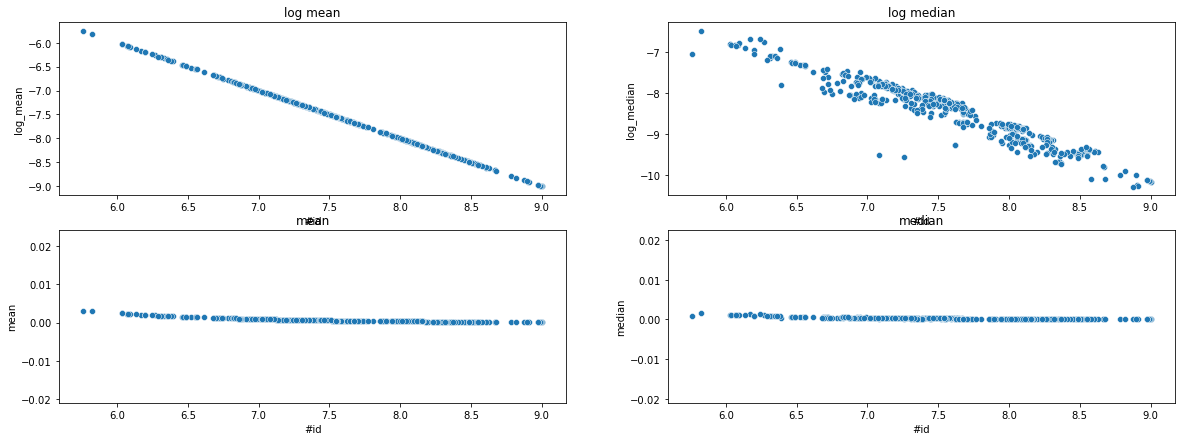

In [56]:
fig, ax = plt.subplots(2,2, figsize = (20,7))

ax[0][0].set_title("log mean")
ax[0][1].set_title("log median")
ax[1][0].set_title("mean")
ax[1][1].set_title("median")

sns.scatterplot(data = abundance_summary, x = "#id", y = "log_mean", ax=ax[0][0])
sns.scatterplot(data = abundance_summary, x = "#id", y = "log_median", ax=ax[0][1])
sns.scatterplot(data = abundance_summary, x = "#id", y = "mean", ax=ax[1][0])
sns.scatterplot(data = abundance_summary, x = "#id", y = "median", ax=ax[1][1])

seems like the function is of form $$ y=ax^{k} $$ with 

y: the mean of the abundances of the proteins identified

x: number of proteins identified

These abundances should have the same mean to make the abundance values comparable across samples

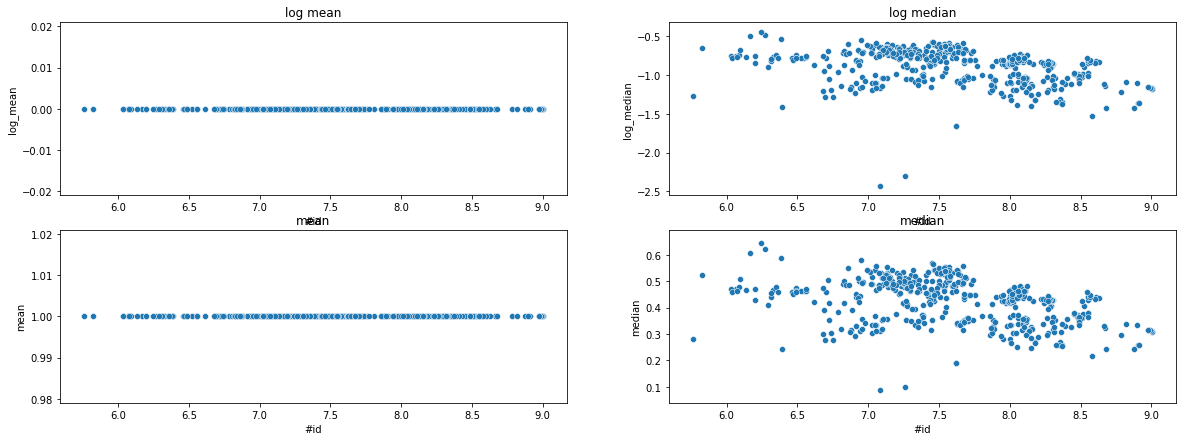

In [9]:
fig, ax = plt.subplots(2,2, figsize = (20,7))

ax[0][0].set_title("log mean")
ax[0][1].set_title("log median")
ax[1][0].set_title("mean")
ax[1][1].set_title("median")

sns.scatterplot(data = absolute_summary, x = "#id", y = "log_mean", ax=ax[0][0])
sns.scatterplot(data = absolute_summary, x = "#id", y = "log_median", ax=ax[0][1])
sns.scatterplot(data = absolute_summary, x = "#id", y = "mean", ax=ax[1][0])
sns.scatterplot(data = absolute_summary, x = "#id", y = "median", ax=ax[1][1])

In [41]:
metadata

,assay_id,cell_line,PXD_accession,tissue_type
0,30960,Hep3B,PXD000533,liver
1,30961,Hep3B,PXD000533,liver
2,31008,MHCC97,PXD000533,liver
3,31009,MHCC97,PXD000533,liver
4,31056,Jurkat,PXD004280,blood
...,...,...,...,...
505,33983,SKOV3,PXD005940,ovary
506,33986,M14,PXD005940,skin
507,33989,MCF7,PXD005940,breast
508,34076,CCRF-CEM,PXD005940,T-cell


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


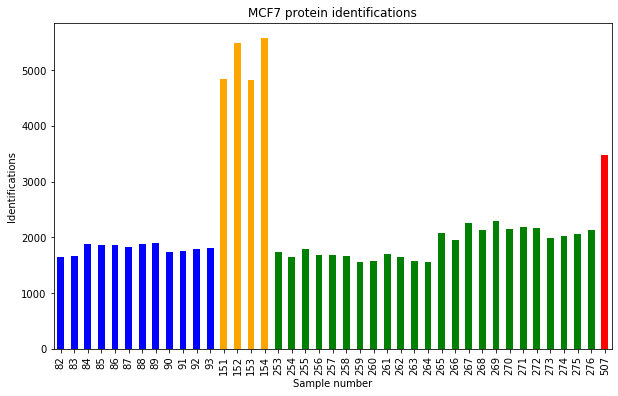

In [43]:
plt.figure(figsize = (10,6))
plt.title("MCF7 protein identifications")
plt.xlabel("Sample number")
plt.ylabel("Identifications")
my_colors = ["blue"]*12 + ["orange"]*4 + ["green"]*24 + ["red"]
dataset.loc[metadata.cell_line == "MCF7",:].notna().sum(axis = 1).plot(kind = "bar", colors = my_colors)

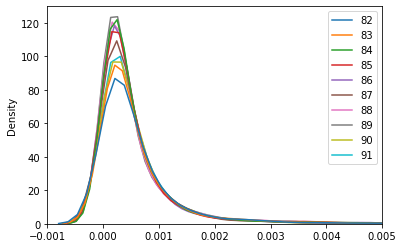

In [22]:
plt.xlim((-0.001,0.005))
sns.kdeplot(data=dataset.loc[range(82,92),:].T)

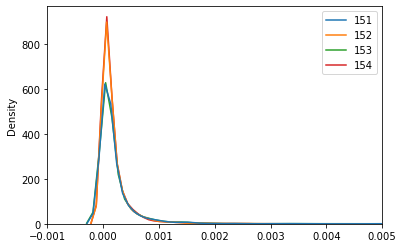

In [24]:
plt.xlim((-0.001,0.005))
sns.kdeplot(data=dataset.loc[range(151,155),:].T)

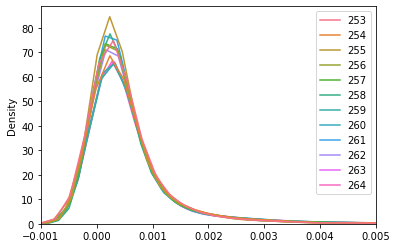

In [26]:
plt.xlim((-0.001,0.005))
sns.kdeplot(data=dataset.loc[range(253,265),:].T)

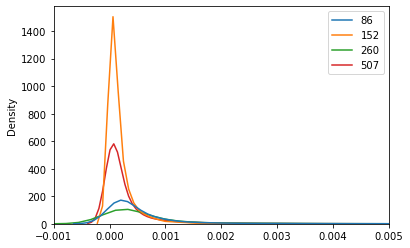

In [39]:
plt.xlim((-0.001,0.005))
sns.kdeplot(data=dataset.loc[[86,152,260,507],:].T)

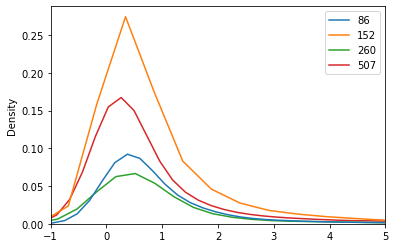

In [36]:
plt.xlim((-1,5))
sns.kdeplot(data=absolute_ab_dataset.loc[[86,152,260,507],:].T)